# Post-stack, time domain Kirchhoff migration

## Anthor: Xiao Ma | xiao.ma@kaust.edu.sa | ID 193561 

Let's start by recalling the equation that can be used to model the propagation of waves from a scatterer at location $(x_s, t_0)$ in the subsurface to co-located sources and receivers at location $(x, t_0=0)$ (i.e., at the surface) under the assumption of laterally homogenous Earth with root-mean-square velocity $v_{rms}(t_0)$:    
$$
t_{kirch}(x_s, t_0, h) = \sqrt{t_0^2 + 4\frac{h^2}{v_{rms}^2}}
$$

where $t_0$ is the zero-offset traveltime, $h=x_s-x$ is the horizontal distance between the subsurface point of interest and the source/receiver.

**Kirchoff migration** refers to the process of taking the data $d(x_s, t)$ and transforming it into an image of the subsurface $i(x, t_0)$ (also called *reflectivity*), which is accomplished by summing all values along the traveltime curve $t_{kirch}(x_s, t_0, x) \; \forall x_s$:

$$
i(x, t_0) = \int \int d(x_s, t_{kirch}(x_s, t_0, x)) d x_s d t_0
$$

**Kirchoff demigration** is the opposite process, which entails modelling the data $d(x_s, t)$ from an image of the subsurface $i(x, t_0)$, which is accomplished by spreading the values of the image along the traveltime curve $t_{kirch}(x_s, t_0, x) \; \forall x$:

$$
d(x, t_{kirch}(x_s, t_0, x)) = \int \int i(x, t_0) d x d t_0
$$

Note that in practical applications, when modelling the data, the output of the above equation is usually convolved with a wavelet. As such, in order for the Kirchoff demigration/migration operator to be consisent, convolution with a time-flipped wavelet is also applied during migration.



In [3]:
%load_ext autoreload

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import lsqr

from pylops.utils.wavelets import *
from pylops.utils import dottest

from timemig import TimeKirchhoff

### test on field data

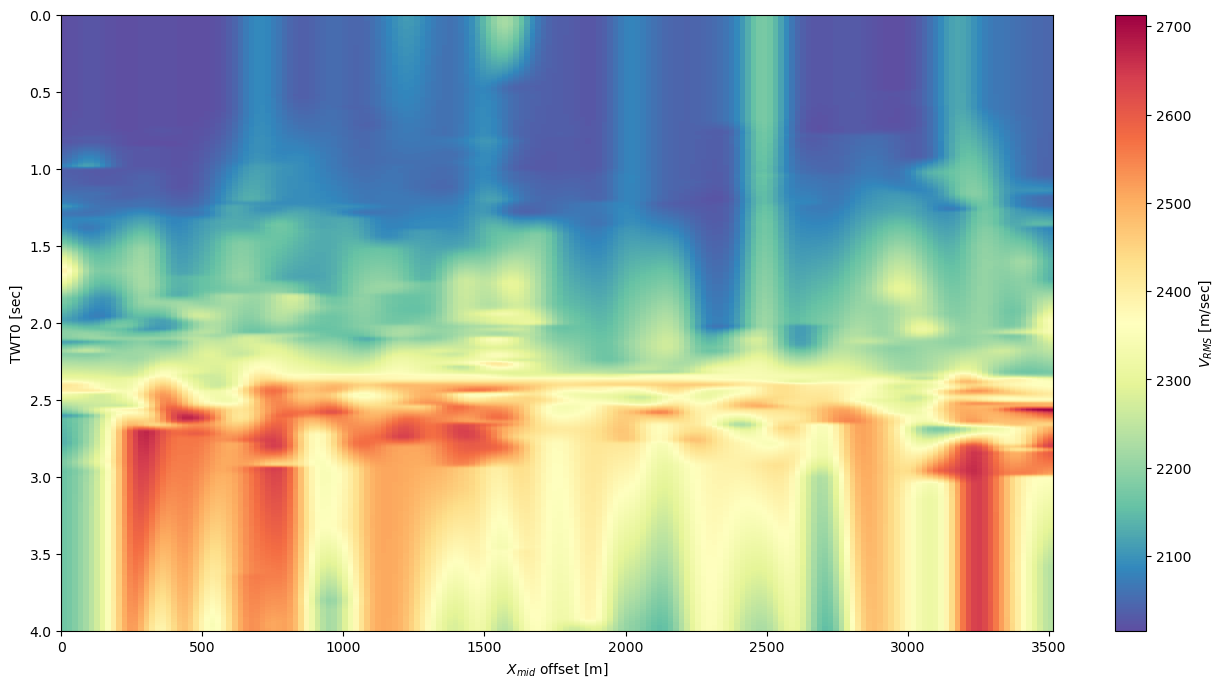

In [6]:


import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import lsqr

from pylops.utils.wavelets import *
from pylops.utils import dottest
from timemig import TimeKirchhoff
velfile = 'vrms_xiao_gaussian.npy'
# Velocity file
fv = np.load(velfile)
plt.figure(figsize=(16, 8))

plt.imshow(fv, aspect='auto', cmap='Spectral_r', extent=(0, 3517, 4, 0), interpolation='none')
plt.colorbar(label='$V_{RMS}$ [m/sec]')

plt.xlabel('$X_{mid}$ offset [m]');
plt.ylabel('TWT0 [sec]');

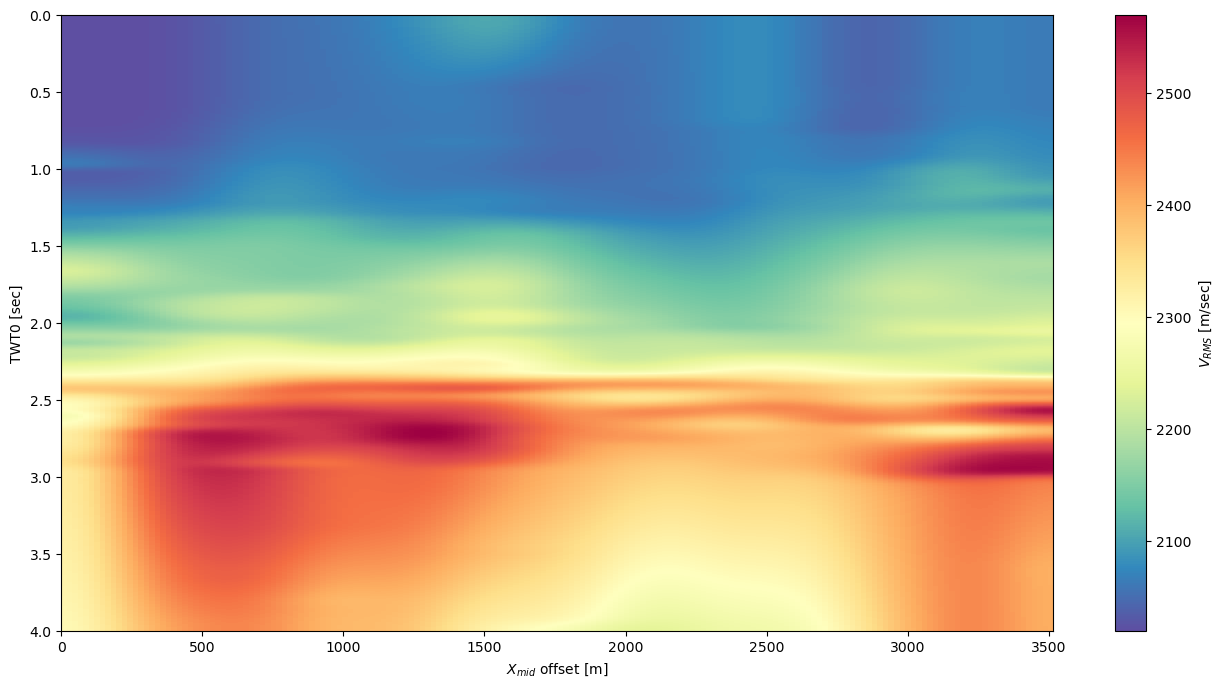

In [7]:
v_mig = np.array(1/gaussian_filter(1/fv, 10))

plt.figure(figsize=(16, 8))

plt.imshow(v_mig , aspect='auto', cmap='Spectral_r', extent=(0, 3517, 4, 0), interpolation='none')
plt.colorbar(label='$V_{RMS}$ [m/sec]')

plt.xlabel('$X_{mid}$ offset [m]');
plt.ylabel('TWT0 [sec]');

In [8]:
# Wavelet

# Axes
nx, nt0 = 180,2000
dx, dt0 = 25, 0.002

x, t0 = np.arange(nx) * dx, np.arange(nt0) * dt0
wav, _, wavc = ricker(t0[:], f0=15)

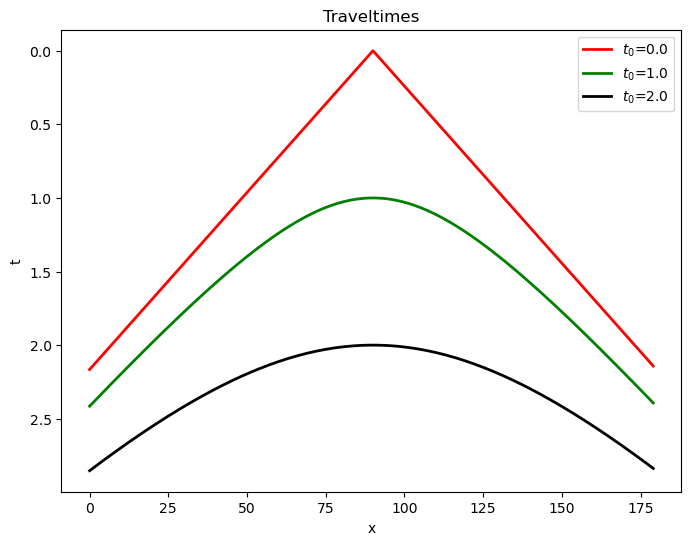

In [9]:
Top = TimeKirchhoff(t0, x, v_mig.T, wav, wavc, engine="numba")
#Top = TimeKirchhoff(t0, x, fv.T, engine="numba")
# Display some traveltimes
plt.figure(figsize=(8, 6))
plt.plot(Top.trav[:, nx//2, 0], 'r', lw=2, label=fr'$t_0$={t0[0]}')
plt.plot(Top.trav[:, nx//2, nt0//4], 'g', lw=2, label=fr'$t_0$={t0[nt0//4]}')
plt.plot(Top.trav[:, nx//2, nt0//2], 'k', lw=2, label=fr'$t_0$={t0[nt0//2]}')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Traveltimes');

### processing the data

In [10]:
data_file = np.load('mdd_volve_for_xiao.npz')
seismic_volume = data_file["Rnsgd"]
print(seismic_volume.shape)

(2000, 180, 180)


In [11]:
########test extract one trace in many shots
com_shot=np.zeros([2000,180])
for i in range(180):
    #for j in range(180):
    com_shot[:,i]=seismic_volume[:,i,i]

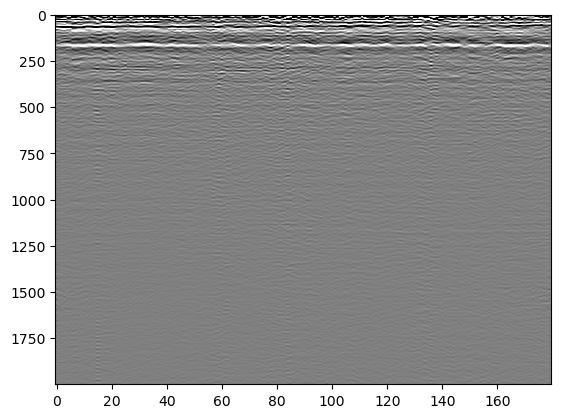

In [12]:
vm= np.percentile(com_shot,99)
plt.imshow(com_shot, aspect="auto",cmap="gray",vmin=-vm,vmax=vm)

In [13]:
com_shot.shape

(2000, 180)

In [ ]:
#np.save("com_shot.npy",com_shot)

In [60]:
#data=np.load("/home/max0b/Seismology/TimeMigration/data_denoise.npy")

In [61]:
# Obtain this velocity from the following Zenodo link: https://zenodo.org/record/6572286#.Y8aDbC8Rr6-)
# v_file = np.load('/home/max0b/Seismology/ReflectionSeismic/VolveSynthetic_ZenodoData/Velocity/Velocities.npz')
# velocity = v_file['vback']

# print(v_file.files)

In [14]:
#using nmo and stack
section_zo=np.load("section_zo.npy")

(3.998, 0.0)

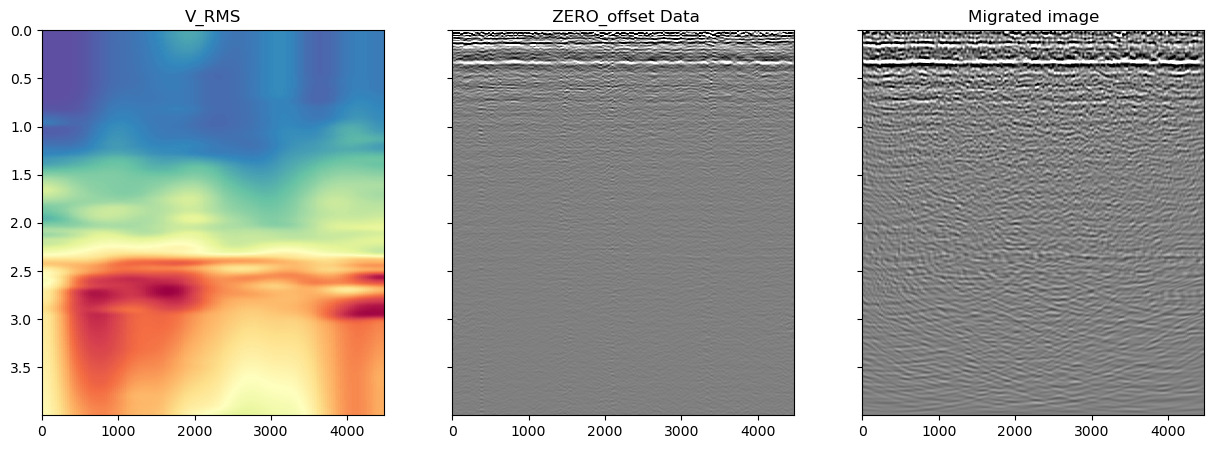

In [15]:
# Model data (demigration)
# data = Top @ refl
# print(data.shape)
# Image data (migration)
#data=seismic_volume[:,1,:]
reflmig = Top.H @ com_shot.T
#reflmig = Top.H @ data
vm=np.percentile(v_mig,99)
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

axs[0].imshow(v_mig, aspect='auto', cmap='Spectral_r', extent=(x[0], x[-1], t0[-1], t0[0]), interpolation='none')
axs[0].axis('tight')
axs[0].set_title('V_RMS')
vm=np.percentile(com_shot,99)
axs[1].imshow(com_shot, cmap='gray', vmin=-vm, vmax=vm, extent=(x[0], x[-1], t0[-1], t0[0]))
#axs[1].plot(x, Top.trav[:, nx//2, nt0//2], 'r')
axs[1].axis('tight')
axs[1].set_title(' ZERO_offset Data')
vm=np.percentile(reflmig,99)
axs[2].imshow(reflmig.T, cmap='gray', vmin=-vm, vmax=vm, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axis('tight')
axs[2].set_title('Migrated image')

axs[2].set_ylim(t0[-1], t0[0])

# axs[3].imshow(velocity, aspect='auto', cmap='Spectral_r', extent=(x[0], x[-1], t0[-1], t0[0]), interpolation='none')
# axs[3].axis('tight')
# axs[3].set_title('V')

# axs[3].set_ylim(t0[-1], t0[0]);

(3.998, 0.0)

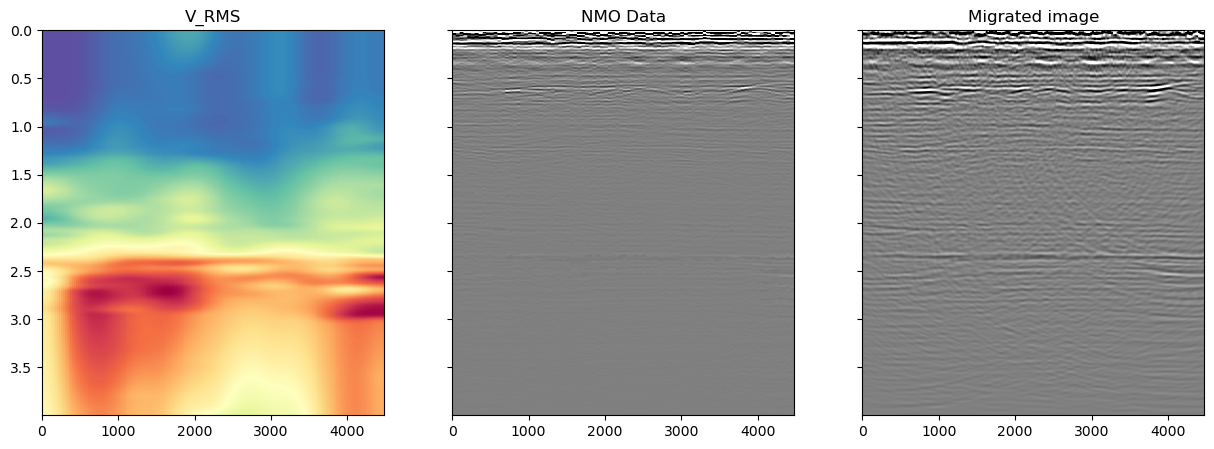

In [16]:
# Model data (demigration)
# data = Top @ refl
# print(data.shape)
# Image data (migration)
#data=seismic_volume[:,1,:]
reflmig = Top.H @ section_zo[:,10:190].T
#reflmig = Top.H @ data
vm=np.percentile(v_mig,99)
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

axs[0].imshow(v_mig, aspect='auto', cmap='Spectral_r', extent=(x[0], x[-1], t0[-1], t0[0]), interpolation='none')
axs[0].axis('tight')
axs[0].set_title('V_RMS')
vm=np.percentile(section_zo[:,10:190],99)
axs[1].imshow(section_zo[:,10:190], cmap='gray', vmin=-vm, vmax=vm, extent=(x[0], x[-1], t0[-1], t0[0]))
#axs[1].plot(x, Top.trav[:, nx//2, nt0//2], 'r')
axs[1].axis('tight')
axs[1].set_title('NMO Data')
vm=np.percentile(reflmig,99)
axs[2].imshow(reflmig.T, cmap='gray', vmin=-vm, vmax=vm, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axis('tight')
axs[2].set_title('Migrated image')

axs[2].set_ylim(t0[-1], t0[0])

